Ссылка на презентацию: https://docs.google.com/presentation/d/1uPZbogCGv4UznE1IvDlcpJ7BS388hUTfAyns4zevWdo/edit?usp=sharing

# E-commerce — Анализ товарного ассортимента

## Описание проекта

Интернет-магазин товаров для дома «Пока все ещё тут» поставил перед аналитиками задачу проанализировать торговый ассортимент. Это поможет магазину стать лучше, а клиентам — обустроить дом своей мечты.

Заказчик - менеджер проекта, который отвечает за актуальность товарного ассортимента.

**Цель проекта:** выявление особенностей продаж товаров из ассортимента интернет-магазина и формулировка рекомендаций для отдела продаж/закупок.

**Задачи проекта:**
* провести исследовательский анализ данных;
* проанализировать торговый ассортимент;
* сформулировать и проверить статистические гипотезы.

## Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в *ecommerce_dataset.csv*:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Шаг 1. Загрузка и предобработка данных

Перед началом работы импортируем нужные библиотеки.

In [1]:
# импорт нужных библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from functools import reduce

import scipy.stats as stats
from scipy import stats as st

Теперь прочитаем файл и посмотрим на таблицу, выведем 10 случайных строк.

In [2]:
# чтение файла
ecom = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')

# просмотр таблицы
ecom.sample(10)

,date,customer_id,order_id,product,quantity,price
1412,2018122818,e88af26b-f634-461d-b6c1-c3e7c8121add,69667,Кондиционер для белья Sandokkaebi Soft Aroma A...,1,262.0
1667,2019020217,9b090857-e0bb-4bb6-b289-a402986601d7,70066,Полки QWERTY Берлин чёрный 44х24х10 см 40х20х1...,2,1987.0
5275,2019061408,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурца сорт Каролина кассета 6 шт E6,1,120.0
4922,2019060910,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
3133,2019042421,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,14688,томата (помидор) Поцелуй герани №66 сорт детер...,2,38.0
2555,2019032916,5bee7748-a089-4d7c-a1ad-075cd8846a41,70862,Сушилка для белья Leifheit 81704 PEGASUS 120 C...,1,3599.0
5425,2019061717,bea7a833-2074-42db-bc49-4457abd3c930,14867,"Пеларгония плющелистная ампельная, диам. 12 см",1,142.0
6459,2019092816,518c441d-9295-4ca0-b652-4662fa383bb2,72792,Сушилка для белья потолочно-настенная Gimi Lif...,1,1574.0
1766,2019021010,411ab440-0631-422d-9999-8d5ef8cec0e2,70185,Искусственный цветок Мимоза пластиковая желтая,2,44.0
6218,2019082914,9521bc4c-d409-4302-b368-5de43fc55a8a,72448,"Ручка мебельная кольцо овальное хром, 1108416",5,29.0


### Обработка значений: замена типов, нижний регистр

Для удобства анализа лучше привести все значения в столбце с наименованиями к нижнему регистру.

In [3]:
# приведение к нижнему регистру
ecom['product'] = ecom['product'].str.lower()

Оценим размеры таблицы и посмотрим на типы данных.

In [4]:
# общая информация по таблице
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Пропусков в таблице нет. Формат даты неверный, нужно исправить. Цену лучше сделать целым числом. 

In [5]:
# замена типов данных
ecom['date'] = pd.to_datetime(ecom['date'], format = '%Y%m%d%H')
ecom['price'] = ecom['price'].astype(int)

### Обработка дубликатов

Проверим данные на наличие дубликатов.

In [6]:
# проверка полных дубликатов
ecom.duplicated().sum()

0

Полных дубликатов нет, но могут быть неполные.

In [7]:
# проверка неполных дубликатов
dublicates_count = ecom.duplicated(['customer_id', 
                                    'order_id', 
                                    'product', 
                                    'price', 
                                    'quantity']).sum()
dublicates_count

1864

Все-таки есть. Оценим долю.

In [8]:
# оценка доли неполных дубликатов
dublicates_part = (dublicates_count/len(ecom)*100).round(1)
dublicates_part

27.7

Больше четверти. Это серьезное число. Смотрим подробнее.

Создаем столбец с указанием дубликатов и делаем фильтрацию. Выведем первые 20 строк.

In [9]:
# просмотр неполных дубликатов
ecom_copy = ecom.copy()
ecom_copy['duplicate'] = ecom_copy.duplicated(['customer_id', 
                                               'order_id', 
                                               'product', 
                                               'price', 
                                               'quantity'])
ecom_copy_is_dublicates = ecom_copy[ecom_copy['duplicate'] == True]
ecom_copy_is_dublicates.head(20)

,date,customer_id,order_id,product,quantity,price,duplicate
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,True
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,True
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,True
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,True
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409,True
126,2018-10-07 17:00:00,ce0e0c29-8c8b-4714-84bd-80957224d4cf,68557,сумка-тележка хозяйственная gimi market синяя,1,1874,True
147,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 15,0 л пищевой овальный ""ekk...",1,209,True
148,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 18,0 л пищевой (иж), 1404047",1,194,True
149,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 20,0 л пищевой (минеральные ...",1,277,True
150,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 24,0 л пищевой круглый (иж),...",1,239,True


Есть человек, купивший четыре гладильных доски с интервалами в 1 час и 9 часов. Также есть человек, купивший четыре пластмассовых таза в 7 вечера и 6 утра следующего дня. Это не выглядит как реальные заказы, похоже на ошибку выгрузки.

Посмотрим содержание заказов с большим количеством дубликатов. Сгруппируем дубликаты по номеру заказа и дате.

In [10]:
# группировка дубликатов по номеру заказа и дате
ecom_copy_is_dublicates_grouped = ecom_copy_is_dublicates.groupby(['order_id', 
                                                                   'date']).agg({'product':'count'})
ecom_copy_is_dublicates_grouped.head(15)

product
order_id date                        
13547    2018-10-23 13:00:00        3
         2018-10-28 19:00:00        3
         2018-11-02 14:00:00        3
         2018-11-10 17:00:00        3
         2018-11-15 15:00:00        3
         2018-11-16 16:00:00        3
14500    2018-10-28 09:00:00        9
         2018-10-31 06:00:00        7
         2018-10-31 13:00:00        8
14504    2018-11-06 07:00:00        4
14505    2018-11-07 07:00:00        5
14521    2019-01-10 18:00:00        3
         2019-01-13 11:00:00        3
         2019-01-19 10:00:00        3
         2019-01-27 11:00:00        3

У заказов 13547 и 14521 в разное время проходит одно и то же количество позиций. Посмотрим, что в них.

In [11]:
# заказ 13547 с дубликатами
ecom[ecom['order_id'] == 13547]

,date,customer_id,order_id,product,quantity,price
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207
104,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни тимьяна в кассете по ...,1,162
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315
377,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни тимьяна в кассете по ...,1,162
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни тимьяна в кассете по ...,1,162
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315


Видно, что это одни и те же позиции, повторяющиеся через определенное время. Посмотрим другой заказ.

In [12]:
# заказ 13521 с дубликатами
ecom[ecom['order_id'] == 14521]

,date,customer_id,order_id,product,quantity,price
1471,2019-01-10 17:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см белая полумах...,1,188
1472,2019-01-10 17:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см красная махровая,1,188
1473,2019-01-10 17:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см темнорозовая ...,1,188
1475,2019-01-10 18:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см белая полумах...,1,188
1476,2019-01-10 18:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см красная махровая,1,188
1477,2019-01-10 18:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см темнорозовая ...,1,188
1500,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см белая полумах...,1,188
1501,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см красная махровая,1,188
1502,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см темнорозовая ...,1,188
1547,2019-01-19 10:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,пеларгония зональная диам. 12 см белая полумах...,1,188


То же самое. На реальное поведение покупателя это непохоже. Скорее всего, в таблицу закрались данные о статусе заказа: оформление, сборка на складе, отправка и т.д.. Или же смешались данные из разных отделов. Возможно, были технические ошибки.

Об этом стоит сообщить коллегам, ответственным за выгрузку, и узнать точные причины и способы устранения проблем. Сейчас же эти дубликаты могут помешать анализу. Удаляем их и оставляем только первые строки с позициями.

In [13]:
# удаление неполных дубликатов
ecom_new = ecom.drop_duplicates(subset = ['customer_id', 
                                          'order_id', 
                                          'product', 
                                          'quantity', 
                                          'price'], 
                                keep = 'first')

### Добавление столбцов

На этом этапе нужно выделить столбцы с временным значением, а также добавить столбец с выручкой.

In [14]:
# столбцы с часом, днем и месяцем
ecom_new['hour'] = ecom_new['date'].dt.hour
ecom_new['month_name'] = ecom_new['date'].dt.month_name()

# функция для определения времени года
def season(month):
    if  month == 'January' or month == 'February' or month == 'December':
        return 'Зима'
    elif month == 'June' or month == 'July' or month == 'August':
        return 'Лето'
    elif month == 'October' or month == 'November' or month == 'September':
        return 'Осень'
    else:
        return "Весна"

# столбец со временем года
ecom_new['season'] = ecom_new['month_name'].apply(season)

# столбец с выручкой
ecom_new['revenue'] = ecom_new['quantity'] * ecom_new['price']

Предобработка данных завершена. Приступим к исследованию.

## Шаг 2. Исследовательский анализ данных

### Обработка аномальных значений

Для начала проверим дату.

In [15]:
# временной отрезок
display(ecom['date'].min())
display(ecom['date'].max())

Timestamp('2018-10-01 00:00:00')

Timestamp('2019-10-31 16:00:00')

Все в порядке, данные есть за нужный период. Теперь посмотрим общую статистику по таблице.

In [16]:
# статистика по данным
ecom_new[['quantity', 'price', 'revenue']].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,4873.0,2.837472,17.606813,1.0,1.0,1.0,1.0,1000.0
price,4873.0,514.749846,944.455480,9.0,90.0,150.0,488.0,14917.0
revenue,4873.0,850.021342,9807.308006,9.0,120.0,194.0,734.0,675000.0


Есть аномальное количество товаров в заказе (1000 единиц) и слишком большая цена (несоизмерима с медианой). Стандартное отклонение и среднее во всех случаях сильно отличаются - везде есть выбросы.

Оценим перцентили для каждого столбца и построим графики типа "ящик с усами".

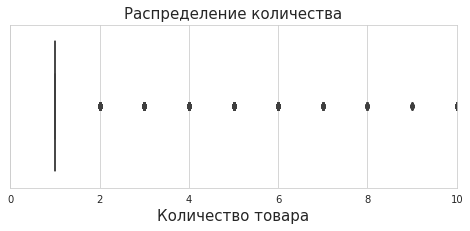

In [17]:
# выбросы значений количества
plt.figure(figsize = (8, 3))
sns.set_style("whitegrid")
ax = sns.boxplot(data = ecom_new, x = 'quantity')
ax.set_xlim([0, 10])
plt.title('Распределение количества', fontsize = 15)
plt.xlabel('Количество товара', fontsize = 15)
plt.show()

In [18]:
# 95-й и 99-й перцентили для количества товаров
np.percentile(ecom_new['quantity'], [95, 99])

array([ 8., 30.])

Самое частое и нормальное значение количества товаров - одна позиция. Все остальное уже считается выбросами. Только 1% товаров покупается в количестве от 30 штук. Посмотрим на эти заказы.

In [19]:
# самые покупаемые позиции - 1%
display(ecom_new[ecom_new['quantity'] > np.percentile(ecom_new['quantity'], 99)])
display((ecom_new[ecom_new['quantity'] > np.percentile(ecom_new['quantity'], 99)]).shape)

,date,customer_id,order_id,product,quantity,price,hour,month_name,season,revenue
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный 2-х рожковый серый металлик с п...,96,38,15,October,Осень,3648
144,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,набор вешалок для костюма 45см 4шт цвет: кремо...,37,202,15,October,Осень,7474
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"стяжка оконная с болтом ст-55 цинк, 1108354",64,19,9,October,Осень,1216
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19,14,October,Осень,2850
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38,14,October,Осень,5700
233,2018-10-12 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68623,"петля приварная гаражная d 14х90 мм с шаром, 1...",50,38,15,October,Осень,1900
278,2018-10-17 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,щетка для посуды *мила* sv3182 1807009,50,27,11,October,Осень,1350
279,2018-10-17 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,"щетка-утюжок с ручкой миди, standart, york, g1126",50,44,11,October,Осень,2200
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51,8,November,Осень,8670
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59,11,November,Осень,8260


(41, 10)

Есть 41 строка. Скорее всего, сделки были оптовые. Лишь одна строка вызывает большие подозрения - 1000 штук вантузов. Выручка по ним неестественно большая. Возможно, значение количества содержит ошибку. Удалим эту строку.

In [20]:
# удаление заказа с 1000 вантузов
ecom_new = ecom_new[ecom_new['order_id'] != 71743]

Теперь оценим значения цены.

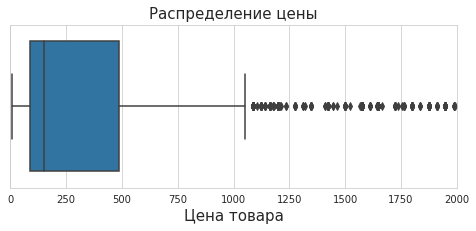

In [21]:
# выбросы значений цены
plt.figure(figsize = (8, 3))
sns.set_style("whitegrid")
ax = sns.boxplot(data = ecom_new, x = 'price')
ax.set_xlim([0, 2000])
plt.title('Распределение цены', fontsize = 15)
plt.xlabel('Цена товара', fontsize = 15)
plt.show()

In [22]:
# 95-й и 99-й перцентили для цены товаров
np.percentile(ecom_new['price'], [95, 99])

array([2174.  , 4951.32])

Нормальным значением цены можно считать цифру чуть больше тысячи. Всего 1% товаров стоит больше 4951 рубля. Посмотрим на них. Может быть, они и правда стоят своих денег.

In [23]:
# самый дорогой 1% товаров
display(ecom_new[ecom_new['price'] > np.percentile(ecom_new['price'], 99)])
display((ecom_new[ecom_new['price'] > np.percentile(ecom_new['price'], 99)]).shape)

,date,customer_id,order_id,product,quantity,price,hour,month_name,season,revenue
98,2018-10-04 17:00:00,d1a13243-9111-454f-848c-dcce0958528c,68529,сумка-тележка хозяйственная andersen scala sho...,1,5024,17,October,Осень,5024
596,2018-11-02 17:00:00,305c9634-ec53-46be-af05-48ee8bd790a5,68836,сумка-тележка хозяйственная andersen scala sho...,1,5249,17,November,Осень,5249
634,2018-11-05 02:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68856,сумка-тележка хозяйственная rolser imx005 mare...,1,6007,2,November,Осень,6007
654,2018-11-05 22:00:00,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,сумка-тележка хозяйственная rolser mou041 malv...,1,7597,22,November,Осень,7597
655,2018-11-05 22:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68871,сумка-тележка хозяйственная rolser imx005 mare...,1,6007,22,November,Осень,6007
768,2018-11-11 18:00:00,06e2fc7e-6183-4419-ada4-3b976baeed92,68952,коврик для ванной комнаты gobi полиэстер 120х7...,1,5474,18,November,Осень,5474
1116,2018-12-06 08:00:00,fa471f6f-1442-490c-acc6-a47b0822098c,69226,сумка-тележка хозяйственная andersen scala sho...,1,5249,8,December,Зима,5249
1121,2018-12-06 17:00:00,82b56a76-0dc9-4dae-aa76-863a9a80f082,69236,покрывало жаккард karna стеганое kalven 260x26...,1,6134,17,December,Зима,6134
1180,2018-12-12 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69320,сумка-тележка хозяйственная andersen treppenst...,1,5662,11,December,Зима,5662
1241,2018-12-17 17:00:00,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,гладильная доска leifheit airboard compact m p...,1,7424,17,December,Зима,7424


(49, 10)

Вышло 49 строк. [Сайт интернет-магазина](https://robinzon.ru/brands/rolser/) указывает на то, что такие цены для сумки-тележки вполне реальны. Стремянки и урны тоже вполне могут стоить недешево. Поэтому оставим эти строки в таблице.

Значения выручки зависят от цены и количества, поэтому посмотрим на распределение значений просто ради интереса.

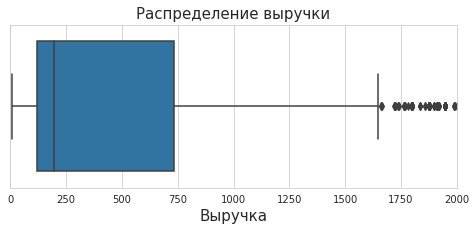

In [24]:
# выбросы значений выручки
plt.figure(figsize = (8, 3))
sns.set_style("whitegrid")
ax = sns.boxplot(data = ecom_new, x = 'revenue')
ax.set_xlim([0, 2000])
plt.title('Распределение выручки', fontsize = 15)
plt.xlabel('Выручка', fontsize = 15)
plt.show()

In [25]:
# 95-й и 99-й перцентили для выручки
np.percentile(ecom_new['revenue'], [95, 99])

array([2849.  , 6138.06])

Границей нормальной выручки можно считать 6138 рублей.

Посмотрим теперь количество заказов на одного пользователя за данный период. Быть может, есть покупатели, которые покупают нереально много.

In [26]:
# количество заказов на пользователя
orders_per_user = ecom_new.groupby('customer_id', 
                                   as_index = False).agg(
    {'order_id': pd.Series.nunique}).sort_values(by = 'order_id', 
                                                 ascending = False)
orders_per_user.head(10)

,customer_id,order_id
1915,c971fb21-d54c-4134-938f-16b62ee86d3b,126
741,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1100,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1747,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
698,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
2146,e0535076-6270-4df2-8621-cb06264a94fa,4
1819,bea7a833-2074-42db-bc49-4457abd3c930,4
1010,6b0c6cfb-7717-4c34-8535-bbc6e2b2c758,3
2208,e8204583-4d55-4724-ad3f-049c7db43bdd,3


Самый преданный покупатель сделал 126 заказов, что выглядит странно. Посмотрим на их содержание, выведем случайные 30 строк.

In [27]:
# заказы покупателя с большим количеством заказов
rich = ecom_new[ecom_new['customer_id'] == 'c971fb21-d54c-4134-938f-16b62ee86d3b']
rich.sample(15)

,date,customer_id,order_id,product,quantity,price,hour,month_name,season,revenue
2209,2019-03-06 12:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70629,сумка-тележка хозяйственная andersen scala sho...,1,3787,12,March,Весна,3787
789,2018-11-12 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68968,герань домашняя (пеларгония зональная) цветуща...,1,149,11,November,Осень,149
1404,2018-12-28 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69652,"корыто оцинкованное 45 л бесшовное, 1303007",1,749,9,December,Зима,749
2173,2019-03-04 16:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70589,калла крупноцветковая желтая,1,374,16,March,Весна,374
1184,2018-12-12 14:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69325,коврик противоскользящий камешки с ракушками о...,1,239,14,December,Зима,239
1180,2018-12-12 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69320,сумка-тележка хозяйственная andersen treppenst...,1,5662,11,December,Зима,5662
880,2018-11-20 14:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69062,чехол для гладильной доски zalger 520111 см ме...,1,434,14,November,Осень,434
1194,2018-12-13 15:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69342,"банка рондо элиз 1л, g8487, luminarc, китай",2,164,15,December,Зима,328
1263,2018-12-19 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69455,коврик противоскользящий пузырьки 70х38 см бир...,2,224,11,December,Зима,448
1203,2018-12-14 14:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69362,сумка-тележка 2-х колесная gimi argo синяя,1,1049,14,December,Зима,1049


Сгруппируем по месяцам и посмотрим количество заказов.

In [28]:
# количество заказов на пользователя со 126 заказами
rich_user = rich.groupby('month_name', as_index = False).agg(
    {'order_id': pd.Series.nunique}).sort_values(by = 'order_id', 
                                                ascending = False)
rich_user

,month_name,order_id
0,December,43
1,February,28
5,October,21
4,November,20
3,March,8
2,January,6


Склоняюсь к тому, что этого пользователя следует удалить, при этом жертвуя частью данных. Пользователи с 35 и 17 заказами, скорее всего, дачники с большими участками или ведут ремонт, поэтому покупают часто.

In [29]:
# удаление пользователя с аномальным числом заказов
ecom_new = ecom_new[(ecom_new['customer_id'] != 'c971fb21-d54c-4134-938f-16b62ee86d3b')]

Посмотрим, как после этого изменились перцентили.

In [30]:
# 95-й и 99-й перцентили для количества товаров
np.percentile(ecom_new['quantity'], [95, 99])

array([ 7., 30.])

Здесь 99-й перцентиль не изменился.

In [31]:
# 95-й и 99-й перцентили для цены товаров
np.percentile(ecom_new['price'], [95, 99])

array([2024.6, 4874. ])

Тут был 4951 рубль, значение немного уменьшилось, но не критично.

Обработка аномальных значений завершена. Приступаем к категоризации товаров, чтобы затем анализировать товарный ассортимент.

### Категоризация товаров

Чтобы определить категорию товаров, нужен список лемм. Из него вручную выделим категории и напишем функцию. Строки с определением лемм будут закомментированы, чтобы сэкономить место.

In [32]:
# лемматизация

# unique_products = ecom_new['product'].unique().tolist()
# m = Mystem()
# string = '; '.join(unique_products)
# lemmas = m.lemmatize(string)
# display(Counter(lemmas))

По результатам лемматизации составляем словарь.

In [33]:
# словарь с категориями товаров
categories = {
    'уход за собой':['мыло','скраб','паста зуб','зубная','пена','увлаж','халат','мыла'],
    
    'хозтовары':['швабр','тряп','ведр','веник','перчатки','мешок','сетка для','таз','ковш',
                 'щетка','ролик','зажигалка','ткань','совок','губка','окномойка','шило',
                 'шпагат','фал капр','пробк','сумка-тележка','тележка','сумка','крепеж',
                 'контейнер','кофр','урна','сушилка','ерш','унитаз','стяжк','свч',
                 'штанга','доска','корзин','коробка','короб','ключница','чехол','бак ','шнур',
                 'ящик','стремянк','пружин','плечик','крючок','прищеп','лоток','пакет',
                 'уголок','сумка для','подрукав','рассек','держат','вантуз','веревка поли',
                 'рукав','бидон','совк','насадка','петля','фиксатор','вкладыши','ложка обув',
                 'покрытие для','завертка','подголовник','сиденье','решетка','сумка для тележки большая'],    
    
    'интерьер':['искусственный цветок','композиция','муляж ','цветок искусственный','искусственная',
                'наматр','наволоч','покрывало','одеял','простын','фоторамка','коврик','штор',
                'плед','ванно','ванну','для ванны','этажерк','полотен','подушка','ваза','комод',
                'ковер придверный','ковров','вешал','карниз','полки q','ручка-','ручка меб',
                'светильник','стеллаж','для обуви','ванна','обувниц','постельное белье',
                'скатерть','пуф'],
    
    'кухня':['тарелка','нож','сковород','хлебница','вилка','ложка ст','чайник','блюд','форм',
             'толкушка','картофелемялка','терка','половник','кастрюля','салатник','кувшин',
             'круж','противень','миска','стакан','выпечк','сито','салфет','венчик','банк',
             'сахарница','рыбочистка','фужер','бокал','орехокол','просеиватель','бульонница',
             'тортница','ножеточка','измельчитель','термос','скребок','шприц','пресс для',
             'чайный','сотейник','скалка','котел','овощечистка','столов','соус','лопатка',
             'масленка','яйц','косточек','набор посуды','дуршлаг','я ложка','ложка ч','ложка к'],
    
    'растения':['каланхое','душица','калла','флокс','сальвия','цинния','петрушка',
                'мелисс','помидор','колокольчик','тыква','эхеверия','фуксия','пуансеттия',
                'львиный зев','пеларгония','спатифиллум','крассула','гипсофила','артемизия',
                'гимнокалициум','чабер','гвоздика','космея','незабудка','валериана','горох',
                'астра','зверобой','арбуз','луковиц','рассада','морковь','нарцисс','бархатцы',
                'пуансетия','фиалка','подарочный','гиностемма','калоцефалус','папоротник',
                'змееголовник','любисток','кипарисовик','сорт','фикус','баклажан ','капуста',
                'алиссум','клубника','бегония','шалфей','гортензия','ранункулус', 'декабрист',
                'буддлея','бузульник','диффенбахия','фиттония','хризантема','эвкалипт','базилик',
                'газания','гардения','тимьян','замиокулькас','клен','сантолина','камнеломка',
                'шпинат','сциндапсус','настурция','кампанула','рудбекия','мединилла','нефролепис',
                'огурец','фаленопсис','розмарин','калибрахоа','тюльпан','герань','примула',
                'аспарагус','эхинокактус','кориандр','вербена','годеция','эшшольция','бадан',
                'скиммия','лапчатка','кореопсис','мимоза','молодило','подсолнечник','шеффлера',
                'агератум','виола','однолетнее','многолетнее','лобелия','календула','осина',
                'хлорофитум','глоксиния','комнатное','плющ','радермахера','хризолидокарпус',
                'суккулент','эпипремнум','петуни','джункус','бальзамин','порей','амариллис',
                'драцена','капсикум','бакопа','барвинок','литопс','комнатное','растение',
                'гербера','азалия','физостегия','кодонанта','платикодон','эхинацея','пахира',
                'энотера','циперус','георгина','гиацинт','лилейник','альбука','целозия','калатея',
                'чабрец','цикламен','портулак','дендробиум','крокусы','ясколка','нолина','роза',
                'дын','аквилегия','дерево','лантана','сосна','мята','кассет','зелени','кашпо',
                'гелихризум','земляника','монарда','адиантум','лаванда','мята','мяты','патиссон',
                'рукола','юкка','овсянница','нивянник','укроп','аптения','черен','гайлардия',
                'цитрофортунелла','вербейник','пеперомия','цинерария','антуриум','дерево ель',
                'каллуна','соланум','хамедорея','котовник','лавр','мирт','алоэ','ель канад',
                'анемон','кофе ','для цветов','кабач','виноград п','фатсия','солидаго','пиретрум',
                'вероника','лен не','седум','афеляндр','импатиенс','хоста','иссоп','муррайя','травы',
                'лаватера','смолевка','томат','d-'],
    
    'техника':['пылесос','утюг','электро','соковыжималка','миксер','пароварка','мантоварка',
               'мясорубка','кипятильник','фен','соковарка','овощеварка'],
   
    'инструменты':['угольник','штангенциркуль','термометр','свар','свер','весы','линейка',
                   'напильн','инструмент'],
    
    'быт.химия':['отбеливатель','порошок','кондиционер','антижир','ополаскиватель','гель',
                 'чистящий','средство','бензин','паста для','бальзам для','концентрат','соль'],

}

Поскольку все товары были записаны в словарь через букву 'е', проведем соответствующую замену в датасете. Затем пишем функцию для категоризации.

In [34]:
# замена буквы ё на е
ecom_new['product'] = ecom_new['product'].str.replace('ё','е')

# функция для категоризации
def category_func(name):
    for key, value in categories.items():
        for word in value:
            if name.find(word) > -1:
                return key
    return 'нет категории'

# создание столбца с категориями
ecom_new['category'] = ecom_new['product'].apply(category_func)

# проверка категоризации всех товаров
ecom_new[ecom_new['category'] == 'нет категории']

,date,customer_id,order_id,product,quantity,price,hour,month_name,season,revenue,category


Для каждого товара определена категория. Посмотрим распределение товаров по категориям. Ожидается, что категория растений будет самой большой.

In [35]:
# размеры категорий
categories_size = ecom_new.groupby('category').agg({'product':'count'}).reset_index()
categories_size['ratio'] = ((categories_size['product'] / len(ecom_new))*100).round(1).astype('str')+'%'
categories_size.sort_values(by = 'product', ascending = False)

,category,product,ratio
4,растения,2461,52.0%
7,хозтовары,1244,26.3%
2,интерьер,643,13.6%
3,кухня,302,6.4%
5,техника,22,0.5%
0,быт.химия,21,0.4%
6,уход за собой,19,0.4%
1,инструменты,17,0.4%


Догадка оказалась верной. Основной ассортимент магазина составляют растения и рассада (более половины), а также товары для хозяйства (24%).

### Анализ товарного ассортимента

Найдем топ-5 самых продаваемых и прибыльных товаров в каждой категории, а также по всем данным.

#### Топ-5 самых продаваемых товаров в каждой категории

In [36]:
# группировка по названиям товаров
groupby_products_count = ecom_new.groupby('product').agg({'category':'first', 
                                                    'order_id':'nunique', 
                                                    'customer_id':'nunique',
                                                    'quantity':'sum',
                                                    'revenue':'sum'}).reset_index().sort_values(by = 'order_id', 
                                                                                                ascending = False)
# топ-5 самых продаваемых товаров в каждой категории
for category in groupby_products_count['category'].unique():
    print()
    display('Топ-5 самых продаваемых товаров: «{}»'.format(category))
    display(groupby_products_count[groupby_products_count['category'] == category].head(5))
    print()

'Топ-5 самых продаваемых товаров: «растения»'

,product,category,order_id,customer_id,quantity,revenue
1015,пеларгония розебудная red pandora укорененный ...,растения,63,62,81,10923
1013,пеларгония розебудная prins nikolai укорененны...,растения,55,54,64,8626
987,пеларгония зональная диам. 12 см сиреневый пол...,растения,52,47,63,10780
1012,пеларгония розебудная mary укорененный черенок,растения,39,35,47,6336
1014,пеларгония розебудная queen ingrid укорененный...,растения,30,28,38,5175


'Топ-5 самых продаваемых товаров: «хозтовары»'

,product,category,order_id,customer_id,quantity,revenue
1575,сумка-тележка 2-х колесная gimi argo синяя,хозтовары,45,42,45,48307
1725,сушилка для белья настенная zalger prima 510-7...,хозтовары,16,15,19,5234
1845,тележка багажная delta тбр-20 синий грузоподъе...,хозтовары,16,16,16,11725
1844,тележка багажная delta тбр-20 коричневый с ора...,хозтовары,13,13,14,9523
1745,"сушилка для белья потолочная лиана 2,0 м 1703009",хозтовары,10,10,10,5990


'Топ-5 самых продаваемых товаров: «интерьер»'

,product,category,order_id,customer_id,quantity,revenue
753,муляж баклажан 18 см,интерьер,10,10,23,1357
804,муляж персики мини полиуретан d-6 см,интерьер,8,9,29,608
792,муляж морковь 16 см,интерьер,7,7,18,1062
815,муляж яблоко зеленый 9 см полиуретан,интерьер,7,10,308,17572
783,муляж красное яблоко мини полиуретан d-6 см,интерьер,7,7,64,1301


'Топ-5 самых продаваемых товаров: «кухня»'

,product,category,order_id,customer_id,quantity,revenue
669,"кувшин пластмассовый с крышкой ""кумган"" 2,0 л ...",кухня,5,5,5,745
372,"измельчитель овощей ручной шк-4 деревянный, 3 ...",кухня,4,4,7,3353
574,"комплект махровых салфеток топ_2, 100% хлопок ...",кухня,3,3,12,1683
908,"нож столовый ripple 80 г 2 шт, attribute, acr042",кухня,3,2,7,1204
1866,термокружка яромир кремль яр-2406м 400 мл,кухня,3,3,3,914


'Топ-5 самых продаваемых товаров: «техника»'

,product,category,order_id,customer_id,quantity,revenue
913,"овощеварка алюминиевая scovo мт-045, хозлэнд, ...",техника,3,3,3,1347
141,"весы электронные кухонные soehnle (круглые,20 ...",техника,2,1,2,2548
1513,соковарка webber ве-06 из нержавеющей стали 6 л,техника,1,1,1,1949
1515,соковыжималка для цитрусовых pasabahce ots1314...,техника,1,1,1,202
1514,"соковарка алюминиевая scovo 6,0 л мт-041, хозл...",техника,1,1,1,1424


'Топ-5 самых продаваемых товаров: «уход за собой»'

,product,category,order_id,customer_id,quantity,revenue
953,паста зубная для профилактики заболеваний десе...,уход за собой,2,2,6,5394
325,дозатор для мыла hausmann белый hm-b0194r-2,уход за собой,2,2,2,958
1968,увлажняющая маска brown rice moisture 330 мл к...,уход за собой,1,1,1,442
2028,"халат вафельный виктория_3-42 , 100% хлопок 26...",уход за собой,1,1,1,1949
356,жидкое мыло vestar хозяйственное 750 мл россия...,уход за собой,1,1,1,59


'Топ-5 самых продаваемых товаров: «быт.химия»'

,product,category,order_id,customer_id,quantity,revenue
1523,средство для мытья пола ecomatic green cleaner...,быт.химия,2,2,2,456
99,"бензин для зажигалок, 1205214",быт.химия,2,2,3,201
1526,средство против засоров в системах водопровода...,быт.химия,1,2,2,246
1525,средство для удаления известкового налета с по...,быт.химия,1,1,1,97
2165,чистящий крем для трудновыводимых пятен mama l...,быт.химия,1,1,1,187


'Топ-5 самых продаваемых товаров: «инструменты»'

,product,category,order_id,customer_id,quantity,revenue
2035,"холодная сварка mastix 55г для труб и батарей,...",инструменты,2,2,3,132
1867,термометр на окно уличный на липучках т-5 h-20...,инструменты,2,2,3,132
1452,"сверло по металлу d=12,0 мм р6м5 с цилиндричес...",инструменты,1,1,1,97
1453,"сверло-фреза, 6 мм, нитрид титана *888* 686206...",инструменты,1,1,1,67
1454,"сверло-фреза, 8 мм, нитрид титана *888* 686208...",инструменты,1,1,1,82


Самые продаваемые товары:
* Растения - пеларгонии;
* Хозтовары - сумка-тележка, багажные тележки и сушилки для белья;
* Интерьер - муляжи;
* Кухня - кувшин, измельчитель овощей, столовый нож и ложка, термокружка;
* Техника - овощеварка, весы, соковарки и соковыжималка;
* Уход за собой - зубная паста, дозатор для мыла, увлажняющая маска, халат, жидкое мыло;
* Быт.химия - средства для мытья полов, для удаления налета и против засоров, бензин для зажигалок и чистящий крем;
* Инструменты - холодная сварка, уличный термометр и сверла.

#### Топ-5 самых прибыльных товаров в каждой категории

In [37]:
# группировка по названиям товаров
groupby_products_revenue = ecom_new.groupby('product').agg({'category':'first', 
                                                        'order_id':'nunique', 
                                                        'customer_id':'nunique',
                                                        'quantity':'sum', 
                                                        'revenue':'sum'}).reset_index().sort_values(by = 'revenue', 
                                                                                                    ascending = False)

# топ-5 самых прибыльных товаров в каждой категории
for category in groupby_products_revenue['category'].unique():
    print()
    display("Топ-5 самых прибыльных товаров: «{}»".format(category))
    display(groupby_products_revenue[groupby_products_revenue['category'] == category].head(5))
    print()

'Топ-5 самых прибыльных товаров: «интерьер»'

,product,category,order_id,customer_id,quantity,revenue
1164,простынь вафельная 200х180 см wellness rw180-0...,интерьер,2,1,30,53232
182,вешалки мягкие для деликатных вещей 3 шт шоколад,интерьер,2,2,335,49596
813,муляж яблоко 9 см красное,интерьер,6,6,618,32702
815,муляж яблоко зеленый 9 см полиуретан,интерьер,7,10,308,17572
517,коврик придверный attribute nature кокосовый 6...,интерьер,4,4,54,16888


'Топ-5 самых прибыльных товаров: «хозтовары»'

,product,category,order_id,customer_id,quantity,revenue
1575,сумка-тележка 2-х колесная gimi argo синяя,хозтовары,45,42,45,48307
1849,тележка багажная delta тбр-22 синий грузоподъе...,хозтовары,3,3,59,33992
1973,"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см...",хозтовары,1,1,5,24370
1601,сумка-тележка хозяйственная andersen scala sho...,хозтовары,4,4,4,22796
124,"веник сорго с деревянной ручкой с 4-мя швами, ...",хозтовары,2,2,37,20010


'Топ-5 самых прибыльных товаров: «кухня»'

,product,category,order_id,customer_id,quantity,revenue
852,набор ножей attribute chef 5 предметов akf522,кухня,1,1,64,29248
1444,салфетка protec textil polyline 30х43 см амети...,кухня,3,3,76,14804
743,"модульная стеклянная банка 1,1л, 298264, braba...",кухня,1,1,7,5775
1833,"тарелка суповая luminarc океан эклипс 20,5 см ...",кухня,2,2,60,4680
658,кружка с трубочкой attribute мяч 500 мл jar501,кухня,1,1,60,4560


'Топ-5 самых прибыльных товаров: «растения»'

,product,category,order_id,customer_id,quantity,revenue
1521,спатифиллум шопен d-12 см,растения,2,2,46,11512
1015,пеларгония розебудная red pandora укорененный ...,растения,63,62,81,10923
987,пеларгония зональная диам. 12 см сиреневый пол...,растения,52,47,63,10780
969,пеларгония зональная диам. 12 см красная махровая,растения,21,21,63,10514
2257,эвкалипт гунни d-17 см h-60 см,растения,6,6,6,9866


'Топ-5 самых прибыльных товаров: «инструменты»'

,product,category,order_id,customer_id,quantity,revenue
847,набор инструментов в алюминиевом кейсе на коле...,инструменты,1,1,1,5399
138,весы напольные edition feet механические,инструменты,1,1,1,1424
856,набор прецизионных напильников с двухкомпонент...,инструменты,1,1,1,779
2188,"штангенциркуль 150 мм пластмассовый, точность ...",инструменты,1,1,15,480
374,"измерительный угольник, длина 15 см, truper, e...",инструменты,1,1,1,449


'Топ-5 самых прибыльных товаров: «уход за собой»'

,product,category,order_id,customer_id,quantity,revenue
953,паста зубная для профилактики заболеваний десе...,уход за собой,2,2,6,5394
2028,"халат вафельный виктория_3-42 , 100% хлопок 26...",уход за собой,1,1,1,1949
726,махровый халат женский размер 44-46 wellness а...,уход за собой,1,1,1,1949
1088,подарочный набор на 8 марта нарцисс 5 луковиц ...,уход за собой,1,1,4,1376
325,дозатор для мыла hausmann белый hm-b0194r-2,уход за собой,2,2,2,958


'Топ-5 самых прибыльных товаров: «техника»'

,product,category,order_id,customer_id,quantity,revenue
139,"весы напольные электронные soehnle pino white,...",техника,1,1,1,2849
141,"весы электронные кухонные soehnle (круглые,20 ...",техника,2,1,2,2548
719,мантоварка-пароварка webber be-81 нержавеющая ...,техника,1,1,1,2219
2261,"электроштопор qwerty белый 4,5?23,4 см на бата...",техника,1,1,2,2024
1513,соковарка webber ве-06 из нержавеющей стали 6 л,техника,1,1,1,1949


'Топ-5 самых прибыльных товаров: «быт.химия»'

,product,category,order_id,customer_id,quantity,revenue
943,ополаскиватель для посудомоечных машин ludwik ...,быт.химия,1,1,2,734
230,гипоаллергенный концентрированный гель для сти...,быт.химия,1,1,1,539
588,концентрат для мытья посуды mama ultimate зеле...,быт.химия,1,1,2,508
1523,средство для мытья пола ecomatic green cleaner...,быт.химия,2,2,2,456
948,отбеливатель пероксоль лилия-м 100 гр россия 4...,быт.химия,1,1,10,370


Самые прибыльные товары:
* Растения - спатифиллум, пеларгонии и эвкалипт;
* Хозтовары - сумки-тележки, багажная тележка, веник и уличная урна;
* Интерьер - простынь, вешалки, муляжи и придверный коврик;
* Кухня - набор ножей, салфетка, стеклянная банка, тарелка и кружка;
* Техника - весы, соковарка, мантоварка и электроштопор;
* Уход за собой - зубная паста, халаты и дозаторы для мыла;
* Быт.химия - ополаскиватель для посудомоечных машин, гель для стирки, концентрат для мытья посуды, средство для мытья пола и отбеливатель;
* Инструменты - набор инструментов, весы, напильники, штангенциркуль и измерительный угольник.

#### Топ-5 самых продаваемых и прибыльных товаров по всем данным

In [38]:
# топ-5 самых продаваемых товаров по всем данным
top_5_count = ecom_new.pivot_table(index = 'product', aggfunc = {'quantity':'sum', 
                                                                 'revenue':'sum'})
top_5_count.sort_values(by = 'quantity', ascending = False).head(5)

,quantity,revenue
product,,
муляж яблоко 9 см красное,618,32702
вешалки мягкие для деликатных вещей 3 шт шоколад,335,49596
муляж яблоко зеленый 9 см полиуретан,308,17572
"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,5800
"крепеж для пружины дверной, 1107055",170,3290


In [39]:
# топ-5 самых прибыльных товаров по всем данным
top_5_count = ecom_new.pivot_table(index = 'product', aggfunc = {'revenue':'sum'})
top_5_count.sort_values(by = 'revenue', ascending = False).head(5)

,revenue
product,
простынь вафельная 200х180 см wellness rw180-01 100% хлопок,53232
вешалки мягкие для деликатных вещей 3 шт шоколад,49596
сумка-тележка 2-х колесная gimi argo синяя,48307
тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,33992
муляж яблоко 9 см красное,32702


Больше всего люди купили муляжей, вешалок, ручек-скоб и крепежей для дверной пружины. Больше всего денег принесли простыни, вешалки, сумки-тележки и багажные тележки, муляжи яблок.

Интересно также посмотреть наименее продаваемые и прибыльные товары.

#### Топ-5 наименее продаваемых товаров по категориям

In [40]:
# топ-5 наименее продаваемых товаров в каждой категории
for category in groupby_products_count['category'].unique():
    print()
    display('Топ-5 наименее продаваемых товаров: «{}»'.format(category))
    display(groupby_products_count[groupby_products_count['category'] == category].tail(5))
    print()

'Топ-5 наименее продаваемых товаров: «растения»'

,product,category,order_id,customer_id,quantity,revenue
829,мята колосистая almira d-7 см,растения,1,1,1,68
828,мята d-9 см,растения,1,1,1,112
827,мята aura d-7 см,растения,1,1,2,136
818,мускари white magic в горшке d-10 см 7 луковиц,растения,1,1,1,127
817,муррайя d-9 см,растения,1,1,1,37


'Топ-5 наименее продаваемых товаров: «хозтовары»'

,product,category,order_id,customer_id,quantity,revenue
834,набор vileda easy wring & clean turbo 151153 в...,хозтовары,1,1,1,2924
820,мусорный контейнер hailo profiline solid 14 05...,хозтовары,1,1,1,2549
819,мусорный контейнер hailo bigbin swing 45 0845-...,хозтовары,1,1,3,16536
846,набор для пикника полимербыт на 4 персоны конт...,хозтовары,1,1,4,1648
2280,ящик почтовый металлический с ушками для навес...,хозтовары,1,1,1,172


'Топ-5 наименее продаваемых товаров: «интерьер»'

,product,category,order_id,customer_id,quantity,revenue
844,набор вешалок универсальных attribute neo blue...,интерьер,1,1,4,1496
843,набор вешалок пластмассовых rozenbal r181900,интерьер,1,1,1,157
842,набор вешалок мягких тканевых с перекладиной и...,интерьер,1,1,15,5970
841,набор вешалок мягких тканевых с перекладиной 3...,интерьер,1,1,2,554
840,набор вешалок для костюма 45см 4шт цвет: кремо...,интерьер,1,1,37,7474


'Топ-5 наименее продаваемых товаров: «кухня»'

,product,category,order_id,customer_id,quantity,revenue
855,набор посуды из нержавеющей стали 12 предметов...,кухня,1,1,1,1874
854,набор ножей webber из нержавеющей стали 7 пред...,кухня,1,1,1,689
853,набор ножей webber из нержавеющей стали 5 пред...,кухня,1,1,1,449
851,"набор махровых салфеток фит_3, 100% хлопок 315...",кухня,1,1,7,1568
849,"набор кружек для пива гамбург 2шт 500мл, h5072...",кухня,1,1,1,187


'Топ-5 наименее продаваемых товаров: «техника»'

,product,category,order_id,customer_id,quantity,revenue
734,миксер электрический погружной delta dl-5061 б...,техника,1,2,2,1918
733,миксер василиса ва-506 белый с красным/малинов...,техника,1,1,1,554
732,миксер delta lux dl-5068 серо-голубой 400 вт 4...,техника,1,1,1,1049
719,мантоварка-пароварка webber be-81 нержавеющая ...,техника,1,1,1,2219
718,"мантоварка алюминиевая 6,0 л 3 сетки белая кал...",техника,1,1,1,1349


'Топ-5 наименее продаваемых товаров: «уход за собой»'

,product,category,order_id,customer_id,quantity,revenue
726,махровый халат женский размер 44-46 wellness а...,уход за собой,1,1,1,1949
825,мыло-скраб с мочалкой люфой мандала около 100 г,уход за собой,1,1,3,225
824,мыло ручной работы сувенир подарок на 8 марта ...,уход за собой,1,1,10,680
823,мыло ручной работы свинюшка в грязюшке 90 г,уход за собой,1,1,8,624
822,мыло жидкое reffil mama utimate облепиха 500 м...,уход за собой,1,1,3,267


'Топ-5 наименее продаваемых товаров: «быт.химия»'

,product,category,order_id,customer_id,quantity,revenue
65,бальзам для мытья посуды mama ultimate ecosoda...,быт.химия,1,1,1,187
230,гипоаллергенный концентрированный гель для сти...,быт.химия,1,1,1,539
952,"паста для полировки ""гои"" 25 гр",быт.химия,1,1,1,15
948,отбеливатель пероксоль лилия-м 100 гр россия 4...,быт.химия,1,1,10,370
943,ополаскиватель для посудомоечных машин ludwik ...,быт.химия,1,1,2,734


'Топ-5 наименее продаваемых товаров: «инструменты»'

,product,category,order_id,customer_id,quantity,revenue
138,весы напольные edition feet механические,инструменты,1,1,1,1424
697,"линейка, длина 30 см, truper, rgl-30/14387",инструменты,1,1,1,247
857,"набор сверел по дереву из 8 шт, 3-10 мм *888* ...",инструменты,1,1,1,194
856,набор прецизионных напильников с двухкомпонент...,инструменты,1,1,1,779
847,набор инструментов в алюминиевом кейсе на коле...,инструменты,1,1,1,5399


Меньше всего продаются:
* Растения - мята, мускари, муррайя;
* Хозтовары - наборы для уборки и пикника, мусорные контейнеры и почтовые ящики;
* Интерьер - наборы вешалок;
* Кухня - наборы посуды, ножей, салфеток, кружек;
* Техника - миксеры, мантоварки;
* Уход за собой - халат и мыло разного рода;
* Быт.химия - бальзам для мытья посуды, гель для стирки, паста для полировки, отбеливатель и ополаскиватель для посудомойки;
* Инструменты - весы, линейка, сверла, напильники и набор инструментов.

#### Топ-5 наименее прибыльных товаров в каждой категории

In [41]:
# топ-5 наименее прибыльных товаров в каждой категории
for category in groupby_products_revenue['category'].unique():
    print()
    display("Топ-5 наименее прибыльных товаров: «{}»".format(category))
    display(groupby_products_revenue[groupby_products_revenue['category'] == category].tail(5))
    print()

'Топ-5 наименее прибыльных товаров: «интерьер»'

,product,category,order_id,customer_id,quantity,revenue
773,"муляж груша мини 2 шт, желтая 4 см",интерьер,1,1,1,29
408,искусственный цветок роза закрытая малая пласт...,интерьер,1,1,1,22
2051,цветок искусственный мак 45 см пластик,интерьер,1,1,1,22
770,муляж гранат мини 4 шт,интерьер,1,1,1,22
2060,цветок искусственный тюльпан 45 см пластик цве...,интерьер,1,1,1,22


'Топ-5 наименее прибыльных товаров: «хозтовары»'

,product,category,order_id,customer_id,quantity,revenue
877,"насадка для мытья окон, мультипласт",хозтовары,1,1,1,38
1364,решетка вентиляционная металлическая золото 17...,хозтовары,1,1,1,30
305,губка спираль металлическая eurohouse 2 шт eh3599,хозтовары,1,1,1,29
703,"ложка обувная металлическая крашенная 220, 120...",хозтовары,1,1,1,22
664,"крючок проволочный 120 мм оцинкованный, 1110212",хозтовары,1,1,1,15


'Топ-5 наименее прибыльных товаров: «кухня»'

,product,category,order_id,customer_id,quantity,revenue
2093,чайная ложка better цветной горох bt-c2003e-td...,кухня,1,1,1,44
1459,сервировочная салфетка пвх 26х41 см капучино 6163,кухня,1,1,2,44
1530,"стакан пластмассовый 300 мл, конус. (к-308) ""п...",кухня,2,2,2,44
186,вилка столовая better цветной горох bt-c2003e-...,кухня,1,1,1,44
729,мерный стакан пластиков 1535026,кухня,1,1,1,22


'Топ-5 наименее прибыльных товаров: «растения»'

,product,category,order_id,customer_id,quantity,revenue
748,морковь детская сладость 2 г 4660010775921,растения,1,1,1,10
2086,"цинния коралловая красавица 0,2 г 4660010773323",растения,1,1,1,10
2087,"цинния оранжевый король 0,5 г 4660010770520",растения,1,1,1,10
301,"горох амброзия 10,0 г 4660010772616",растения,1,1,1,9
714,"львиный зев волшебный ковер 0,05 г 4660010779639",растения,1,1,1,9


'Топ-5 наименее прибыльных товаров: «инструменты»'

,product,category,order_id,customer_id,quantity,revenue
2036,"холодная сварка mastix 55г универсальная, 1205037",инструменты,1,1,2,104
1452,"сверло по металлу d=12,0 мм р6м5 с цилиндричес...",инструменты,1,1,1,97
1454,"сверло-фреза, 8 мм, нитрид титана *888* 686208...",инструменты,1,1,1,82
1453,"сверло-фреза, 6 мм, нитрид титана *888* 686206...",инструменты,1,1,1,67
1868,термометр уличный оконный тб 202 h-20 см 1210036,инструменты,1,1,1,37


'Топ-5 наименее прибыльных товаров: «уход за собой»'

,product,category,order_id,customer_id,quantity,revenue
368,зубная паста systema tartar против образования...,уход за собой,1,1,1,194
369,зубная паста zact lion smokers toothpaste 100 ...,уход за собой,1,1,1,134
370,зубная паста zact lion whitening toothpaste 10...,уход за собой,1,1,1,134
1019,пена для ванн vestar хвойная пихта 900 мл росс...,уход за собой,1,1,1,82
356,жидкое мыло vestar хозяйственное 750 мл россия...,уход за собой,1,1,1,59


'Топ-5 наименее прибыльных товаров: «техника»'

,product,category,order_id,customer_id,quantity,revenue
1987,фен дорожный delta dl-0904 бордовый с черным 2...,техника,1,1,1,592
733,миксер василиса ва-506 белый с красным/малинов...,техника,1,1,1,554
471,"кипятильник электрический 2.5 квт, 1601143",техника,1,1,1,224
1515,соковыжималка для цитрусовых pasabahce ots1314...,техника,1,1,1,202
21,антинакипин для утюгов ампулы 10 мл по 5 шт un...,техника,1,1,1,164


'Топ-5 наименее прибыльных товаров: «быт.химия»'

,product,category,order_id,customer_id,quantity,revenue
2165,чистящий крем для трудновыводимых пятен mama l...,быт.химия,1,1,1,187
1525,средство для удаления известкового налета с по...,быт.химия,1,1,1,97
1971,универсальное средство на основе хлора ддля чи...,быт.химия,1,1,1,82
1524,средство для мытья посуды vestar гранат 1000 м...,быт.химия,1,1,1,82
952,"паста для полировки ""гои"" 25 гр",быт.химия,1,1,1,15


Наименее прибыльны:
* Растения - семена моркови, цинния, горох и львиный зев;
* Хозтовары - ложка обувная, насадка для мытья окон, решетка вентиляционная, губка, крючок проволочный;
* Интерьер - муляжи груши и граната, искусственные цветы;
* Кухня - чайная ложка и вилка, мерный стакан, стаканы и сервировочная салфетка;
* Техника - фен, миксер, кипятильник, соковыжималка, антинакипин;
* Уход за собой - зубная паста, пена для ванн, жидкое мыло;
* Быт.химия - чистящий крем, средства для удаления налета и мытья посуды, чистки, паста для полировки;
* Инструменты - холодная сварка, сверло, термометр уличный.

#### Топ-5 наименее продаваемых и прибыльных товаров по всем данным

In [42]:
# топ-5 наименее продаваемых товаров по всем данным
top_5_count = ecom_new.pivot_table(index = 'product', aggfunc = {'quantity':'sum', 
                                                                 'revenue':'sum'})
top_5_count.sort_values(by = 'quantity', ascending = False).tail(5)

,quantity,revenue
product,,
пеларгония зональная диам. 12 см ярко розовая полумахровая,1,150
пеларгония душистая d-13 см,1,149
пеларгония d-13 см с топпером на день учителя в подарочной упаковке,1,277
пахира акватика мультистем d-17 см h-45 см,1,1087
ящик почтовый металлический с ушками для навесного замка домик 1205251,1,172


Меньше всего продаются некоторые растения и почтовый ящик.

In [43]:
# топ-5 наименее прибыльных товаров по всем данным
top_5_count = ecom_new.pivot_table(index = 'product', aggfunc = {'revenue':'sum'})
top_5_count.sort_values(by = 'revenue', ascending = False).tail(5)

,revenue
product,
морковь детская сладость 2 г 4660010775921,10
"цинния коралловая красавица 0,2 г 4660010773323",10
"цинния оранжевый король 0,5 г 4660010770520",10
"горох амброзия 10,0 г 4660010772616",9
"львиный зев волшебный ковер 0,05 г 4660010779639",9


Меньше всего денег приносят некоторые семена.

Продолжим анализ. Оценим продажи по временным отрезкам (часы, дни недели, сезон).

### Оценка продаж и выручки во временном срезе

Сначала посмотрим, в каком количестве продаются товары, затем определим, какие категории приносят больше всего денег.

#### Оценка продаж во времени

Оценим продажи целиком за весь период.

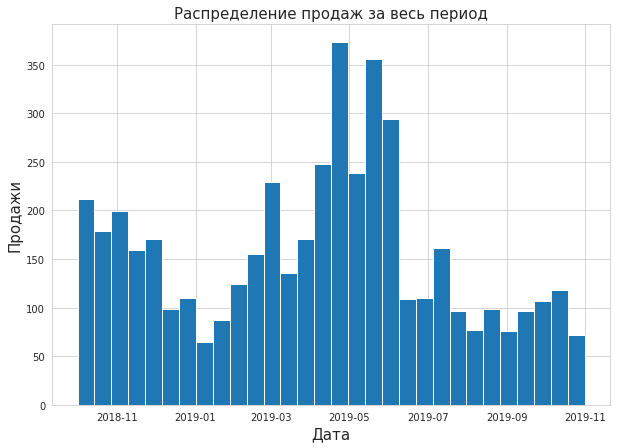

In [44]:
# общие продажи за весь период
plt.figure(figsize = (10,7)) 
ecom_new['date'].hist(bins = 30, grid = True)
plt.title('Распределение продаж за весь период', fontsize = 15)
plt.xlabel('Дата', fontsize = 15)
plt.ylabel('Продажи', fontsize = 15)
plt.show()

Сезонность все же наблюдается. В осенне-зимний период покупают меньше, а весной-летом начинается время дачников и садоводов, во время отпуска многие делают ремонт.

Оценим количество заказов по категориям.

#### Продажи по категориям в зависимости от времени года и месяца

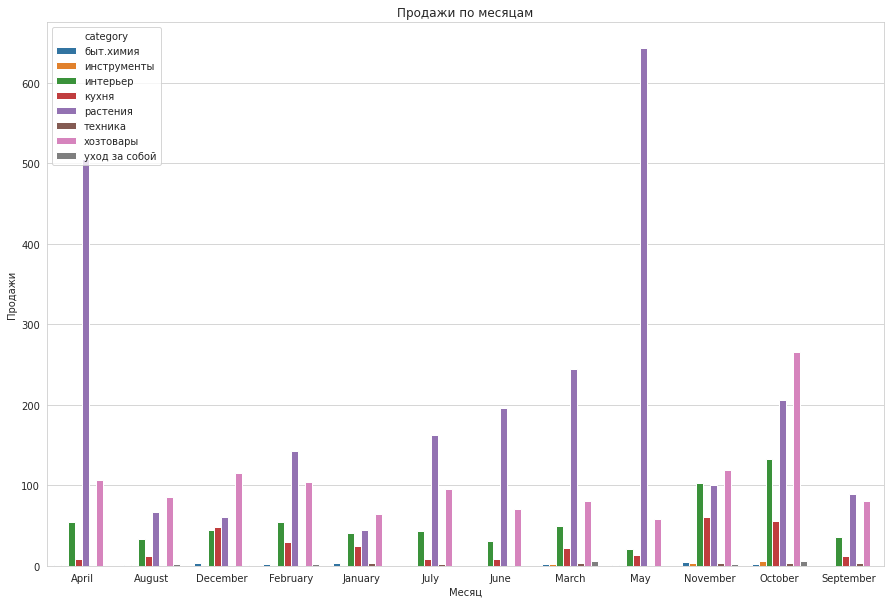

In [45]:
# продажи по месяцам
cat_sales_by_months = ecom_new.groupby(['month_name',
                                       'category'])['order_id'].count().reset_index().sort_values(by = 'month_name')
plt.figure(figsize = (15,10))
sns.barplot(x = 'month_name', 
            y = 'order_id', 
            data = cat_sales_by_months, 
            hue = 'category', 
            dodge = True)
plt.xlabel('Месяц')
plt.title('Продажи по месяцам')
plt.ylabel('Продажи')
plt.show()

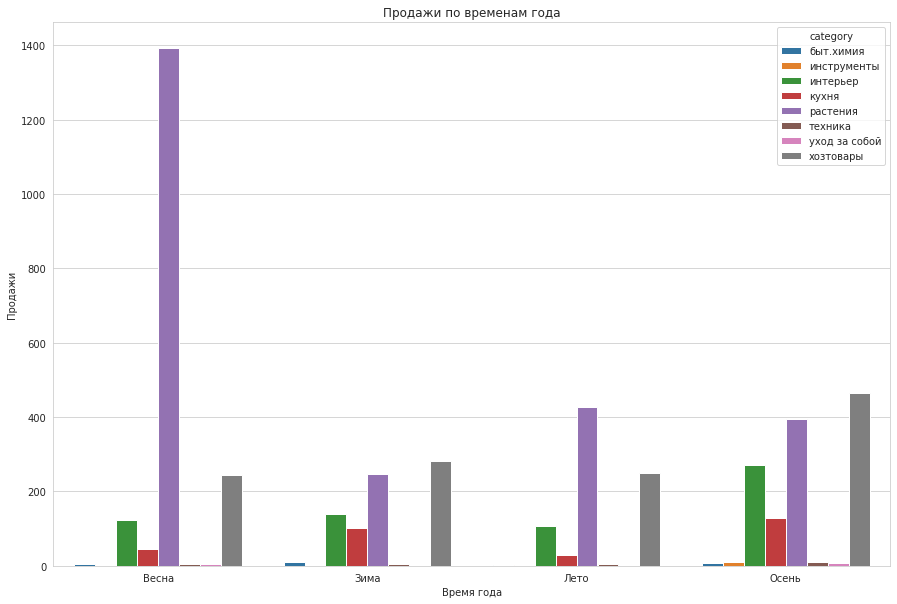

In [46]:
# продажи по времени года
cat_sales_by_seasons = ecom_new.groupby(['season',
                                       'category'])['order_id'].count().reset_index()
plt.figure(figsize = (15,10))
sns.barplot(x = 'season', 
            y = 'order_id', 
            data = cat_sales_by_seasons, 
            hue = 'category', 
            dodge = True)
plt.xlabel('Время года')
plt.title('Продажи по временам года')
plt.ylabel('Продажи')
plt.show()

Продажи в категориях растений и хозтоваров лидируют в любое время года. Растения больше всего продаются в весенне-летние месяцы (время садоводства). Также заметно большое количество продаж предметов интерьера в осенние месяцы. Товары для кухни больше продаются в осенне-зимние месяцы.

#### Продажи по категориям в зависимости от времени суток

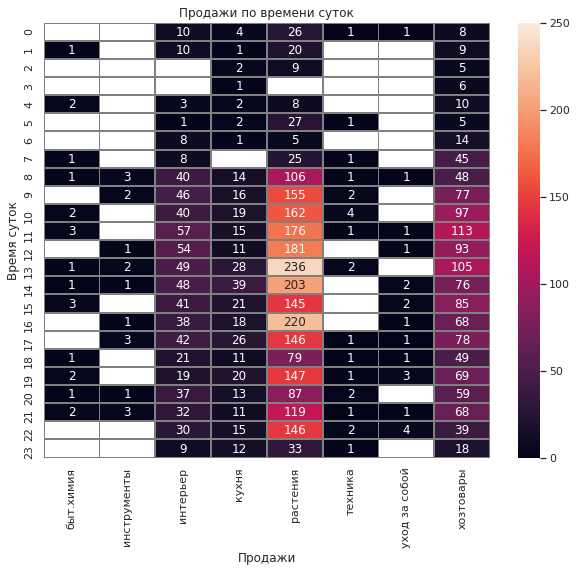

In [47]:
# сводная таблица по часам и категориям
cat_sales_by_hours = ecom_new.pivot_table(index = 'hour',
                                          columns = 'category',
                                          values = 'order_id', 
                                          aggfunc = 'count')

# тепловая карта
sns.set(style = 'white')
plt.figure(figsize = (10, 8))
sns.heatmap(cat_sales_by_hours, 
            annot = True, 
            fmt = 'g', 
            linewidths = 1, 
            linecolor = 'gray', 
            vmin = 0, 
            vmax = 250)
plt.xlabel('Продажи')
plt.title('Продажи по времени суток')
plt.ylabel('Время суток')
plt.show()

Основные продажи происходят примерно с 8 до 22 часов. По категориям растений, хозтоваров, интерьера и кухни есть небольшие продажи в период с полуночи до утра. Пик продаж приходится на 13-14 часов.

#### Оценка выручки во времени

In [48]:
# короткие названия месяцев
ecom_new = ecom_new.replace({'month_name':{'October':'Oct',
                                           'December':'Dec',
                                           'November':'Nov',
                                           'January':'Jan',
                                           'August':'Aug',
                                           'February':'Feb',
                                           'September':'Sep'}})

Оценим выручку по месяцам.

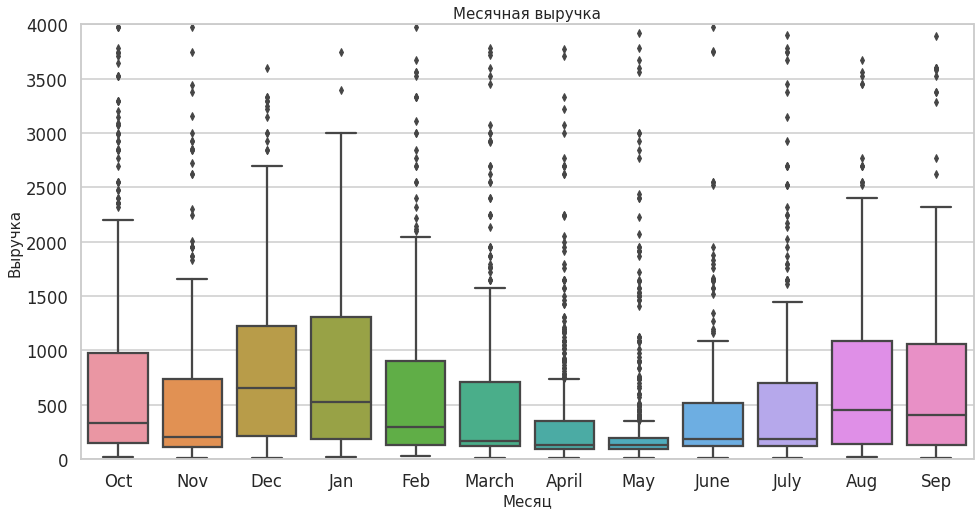

In [49]:
# выручка по месяцам
sns.set(rc = {'figure.figsize':(16, 8)})
sns.set_style('whitegrid')  
sns.set_context('talk')
sns.boxplot(x = 'month_name', 
            y = 'revenue', 
            data = ecom_new).set_ylim(-1, 4000)
plt.title('Месячная выручка', fontsize = 15)
plt.xlabel('Месяц', fontsize = 15)
plt.ylabel('Выручка', fontsize = 15)
plt.show()

Здесь картина обратная продажам. Осенью-зимой приходит больше денег. Возможно, это связано с низкой стоимостью растений и рассады, которую покупают много, и более высокой стоимостью хозтоваров и предметов интерьера, которые стоят дороже, но покупаются в меньшем объеме.

Оценим временной срез продаж по категориям.

#### Выручка по категориям в зависимости от времени года и месяца

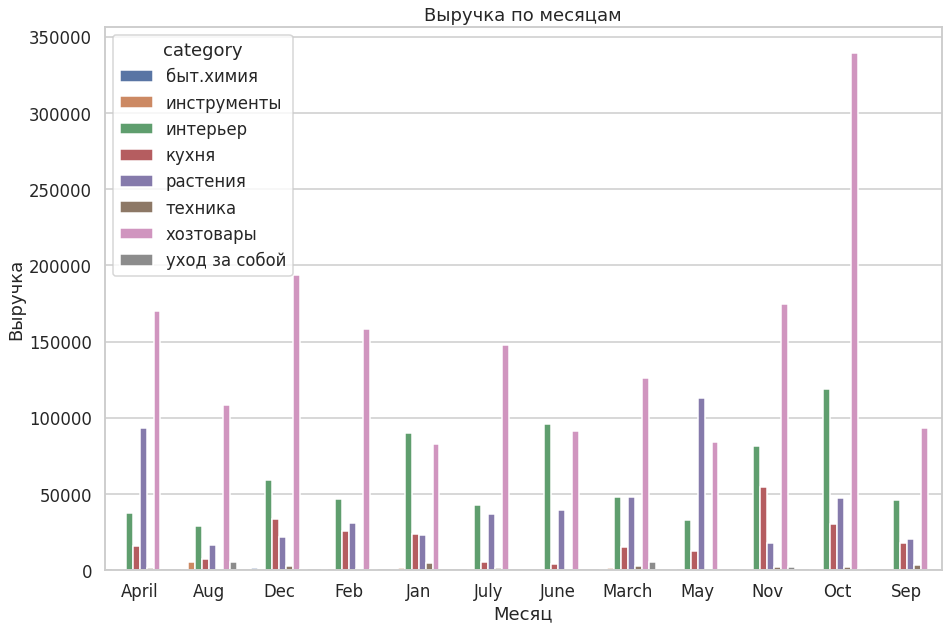

In [50]:
# выручка по месяцам
cat_revenue_by_months = ecom_new.groupby(['month_name',
                                       'category'])['revenue'].sum().reset_index().sort_values(by = 'month_name')
plt.figure(figsize = (15,10))
sns.barplot(x = 'month_name', 
            y = 'revenue', 
            data = cat_revenue_by_months, 
            hue = 'category', 
            dodge = True)
plt.xlabel('Месяц')
plt.title('Выручка по месяцам')
plt.ylabel('Выручка')
plt.show()

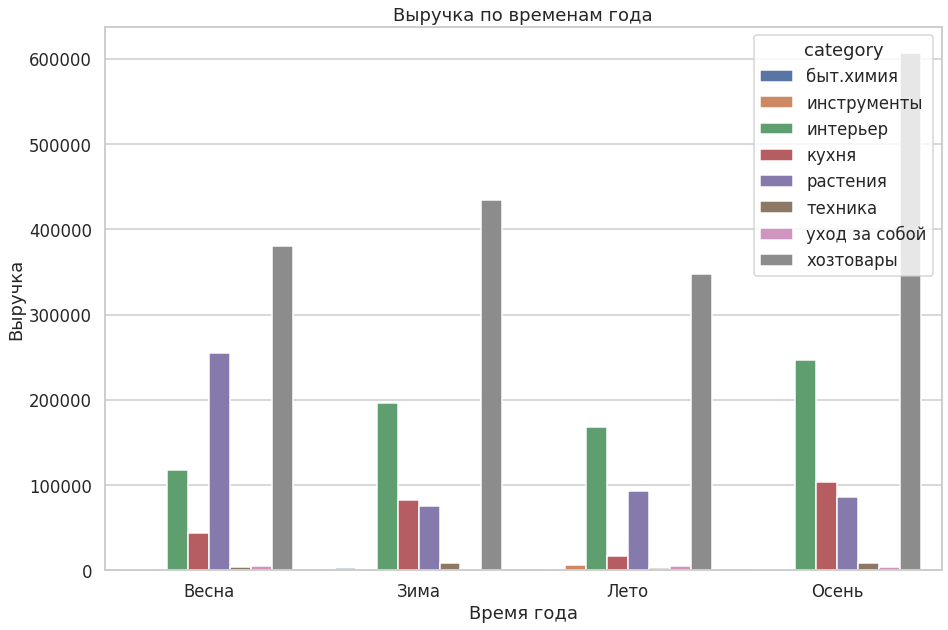

In [51]:
# выручка по времени года
cat_revenue_by_seasons = ecom_new.groupby(['season',
                                       'category'])['revenue'].sum().reset_index()
plt.figure(figsize = (15,10))
sns.barplot(x = 'season', 
            y = 'revenue', 
            data = cat_revenue_by_seasons, 
            hue = 'category', 
            dodge = True)
plt.xlabel('Время года')
plt.title('Выручка по временам года')
plt.ylabel('Выручка')
plt.show()

По выручке лидируют хозтовары и растения (наверное, в силу количества продаж), а также предметы интерьера (в силу своей цены). Растения приносят больше всего денег весной, хозтовары прибыльны осенью и чуть меньше зимой. Предметы интерьера выгоднее продаются осенью. Кухонные принадлежности лучше всего прибыльны в ноябре.

#### Выручка по категориям в зависимости от времени суток

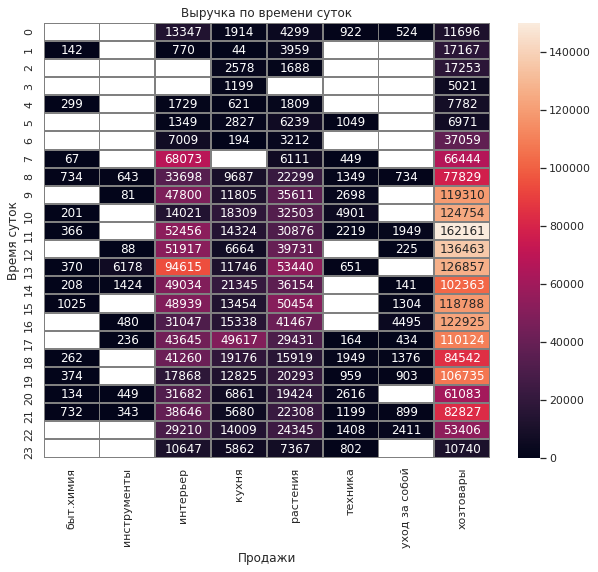

In [52]:
# сводная таблица по часам и категориям
cat_revenue_by_hours = ecom_new.pivot_table(index = 'hour',
                                            columns = 'category',
                                            values = 'revenue', 
                                            aggfunc = 'sum')

# тепловая карта
sns.set(style = 'white')
plt.figure(figsize = (10, 8))
sns.heatmap(cat_revenue_by_hours, 
            annot = True, 
            fmt = 'g', 
            linewidths = 1, 
            linecolor = 'gray', 
            vmin = 0, 
            vmax = 150000)
plt.xlabel('Продажи')
plt.title('Выручка по времени суток')
plt.ylabel('Время суток')
plt.show()

Основная масса денег приходит с 7-8 до 22 часов. Пик прибыльности приходится на 11-12 часов.

Осталось выделить основной и дополнительный ассортимент магазина. Посмотрим, какие категории встречаются в чеках совместно с другими и отдельно.

In [53]:
# количество категорий в чеке
cat_by_receipt = ecom_new.groupby(['order_id'], as_index = False).agg({'category':pd.Series.nunique})
cat_by_receipt.sort_values(by = 'category', ascending = False)

,order_id,category
650,69090,5
696,69177,3
412,68642,3
435,68682,3
337,68521,3
...,...,...
913,69661,1
914,69663,1
915,69665,1
916,69667,1


Выберем заказы с несколькими категориями и посмотрим, как они между собой сочетаются.

In [54]:
# заказы с несколькими категориями
more_than_one_cat = cat_by_receipt[cat_by_receipt['category'] > 1]
cat_combinations = ecom_new.loc[ecom_new['order_id'].isin(more_than_one_cat['order_id'])]
cat_combinations_table = cat_combinations.pivot_table(index = ['order_id', 'category'], 
                                                      values = 'quantity', 
                                                      aggfunc = 'count').reset_index()
# объединение категорий
def unite_areas(series):
    return reduce(lambda x, y: x + ', ' + y, series)
pd.set_option('display.max_colwidth', -1)
cat_together = cat_combinations_table.groupby('order_id', as_index = False).agg({'category': unite_areas})

# сочетания категорий
cat_together['category'].value_counts()

растения, хозтовары                                14
интерьер, хозтовары                                11
кухня, хозтовары                                   2 
интерьер, растения                                 2 
интерьер, кухня, хозтовары                         2 
быт.химия, интерьер, хозтовары                     2 
интерьер, кухня                                    1 
кухня, растения, хозтовары                         1 
интерьер, кухня, уход за собой                     1 
быт.химия, растения, хозтовары                     1 
техника, хозтовары                                 1 
быт.химия, интерьер, кухня, растения, хозтовары    1 
интерьер, растения, уход за собой                  1 
инструменты, кухня, хозтовары                      1 
интерьер, растения, хозтовары                      1 
интерьер, кухня, техника                           1 
кухня, растения                                    1 
Name: category, dtype: int64

Хозтовары часто берут с другими категориями, особенно с растениями и интерьером. Кухня редко встречается в связке с другими категориями, как и бытовая химия с товарами для ухода за собой. Сочетания с техникой встречаются лишь два раза.

Теперь нужно посмотреть, как часто заказы только с одной категорией встречаются среди всех заказов в категории, чтобы определить их "самостоятельность".

In [55]:
# фильтрация заказов с одной категорией
one_cat = cat_by_receipt[cat_by_receipt['category'] == 1]
orders_with_one_cat = ecom_new.loc[ecom_new['order_id'].isin(one_cat['order_id'])]

orders_with_one_cat_count = orders_with_one_cat.groupby('category', as_index = False).\
                            agg({'order_id':'count'}).sort_values(by = 'order_id', ascending = False)
merged_table_cat = orders_with_one_cat_count.merge(categories_size[['category', 'product']], 
                                                   how = 'left', 
                                                   on ='category')
# доля заказов с одной категорией
merged_table_cat['part'] = merged_table_cat['order_id']/merged_table_cat['product']
merged_table_cat.sort_values(by = 'part', ascending = False)

,category,order_id,product,part
1,хозтовары,1178,1244,0.946945
2,интерьер,597,643,0.928460
4,техника,20,22,0.909091
3,кухня,274,302,0.907285
0,растения,2231,2461,0.906542
5,инструменты,15,17,0.882353
7,уход за собой,14,19,0.736842
6,быт.химия,14,21,0.666667


Предположительно, чем выше доля заказов с одной категорией, тем чаще покупатель приходит в магазин именно за ней, и тем больше ее можно считать основной среди всего ассортимента. То есть, основными категориями в магазине являются хозтовары и предметы интерьера. Затем примерно на одном уровне идут техника, кухонные товары и растения (комнатные, рассада и семена). Инструменты, товары по уходу за собой и бытовую химию покупают чаще в связке с другими товарами.

## Шаг 3. Проверка статистических гипотез

### Гипотеза о равенстве средних чеков основных и дополнительных категорий

На данных о заказах с одной категорией проверим, приносят ли основные и дополнительные категории товаров разную выручку. Если так и есть, то действительно можно выделять основной и дополнительный ассортимент. Сравним, например, средние чеки в таких парах категорий: хозтовары (основная) и инструменты (дополнительная), хозтовары (основная) и растения (смежная), интерьер (основная) и инструменты (дополнительная). Также попробуем сравнить инструменты (дополнительная) и растения (смежная).

In [56]:
# независимые выборки
cat_interior = orders_with_one_cat[orders_with_one_cat['category'] == 'интерьер'].\
                                                groupby('order_id', as_index = False).agg({'revenue':'sum'})
cat_interior = cat_interior['revenue']

cat_household = orders_with_one_cat[orders_with_one_cat['category'] == 'хозтовары'].\
                                                groupby('order_id', as_index = False).agg({'revenue':'sum'})
cat_household = cat_household['revenue']

cat_plants = orders_with_one_cat[orders_with_one_cat['category'] == 'растения'].\
                                                groupby('order_id', as_index = False).agg({'revenue':'sum'})
cat_plants = cat_plants['revenue']

cat_instruments = orders_with_one_cat[orders_with_one_cat['category'] == 'инструменты'].\
                                                groupby('order_id', as_index = False).agg({'revenue':'sum'})
cat_instruments = cat_instruments['revenue']

Для четырех проверок применяем поправку Бонферрони.

In [57]:
# критический уровень статистической значимости
alpha_1 = 0.05/4

Сравниваем чеки хозтоваров и инструментов.

* Н0: средний чек категорий хозтоваров и инструментов не отличается;
* Н1: средний чек категорий хозтоваров и инструментов отличается.

In [58]:
# хозтовары и инструменты
results = stats.mannwhitneyu(cat_household, cat_instruments) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.011679202206604185
Отвергаем нулевую гипотезу


Можно сделать вывод о различии средних чеков в паре категорий хозтовары (основная) и инструменты (дополнительная).

Сравниваем чеки хозтоваров и растений.

* Н0: средний чек категорий хозтоваров и растений не отличается;
* Н1: средний чек категорий хозтоваров и растений отличается.

In [59]:
# хозтовары и растения
results = stats.mannwhitneyu(cat_household, cat_plants) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.742891263074643e-58
Отвергаем нулевую гипотезу


Можно сделать вывод о различии средних чеков в паре категорий хозтовары (основная) и растения (смежная).

Сравниваем чеки интерьера и инструментов.

* Н0: средний чек категорий интерьера и инструментов не отличается;
* Н1: средний чек категорий интерьера и инструментов отличается.

In [60]:
# интерьер и инструменты
results = stats.mannwhitneyu(cat_interior, cat_instruments) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.24959468422332654
Не получилось отвергнуть нулевую гипотезу


Нельзя сделать вывод о различии средних чеков в паре категорий интерьер (основная) и инструменты (дополнительная).

Сравниваем чеки растений и инструментов.

* Н0: средний чек категорий растений и инструментов не отличается;
* Н1: средний чек категорий растений и инструментов отличается.

In [61]:
# растения и инструменты
results = stats.mannwhitneyu(cat_plants, cat_instruments) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8737587183073499
Не получилось отвергнуть нулевую гипотезу


Выходит, хозтовары отличаются по выручке от растений и инструментов, которые не отличаются по чеку. Инструменты также не отличаются по выручке от предметов интерьера, которые идут сразу за хозтоварами. Учитывая, что в хозтоварах примерно в два раза больше заказов, я бы определила их как основной ассортимент товаров, а соседнюю категорию интерьера и все остальные как дополнительный ассортимент, включая растения, которые больше всего продаются, но не сравнимы с хозтоварами по среднему чеку.

### Гипотеза о равенстве средних чеков в разное время года

Важно также установить сезонность для магазина. Может быть, в какое-то время года выручка больше всего.

In [62]:
# независимые выборки
winter = ecom_new[ecom_new['season'] == 'Зима'].\
                            groupby('order_id', as_index = False).agg({'revenue':'sum'})
winter = winter['revenue']

summer = ecom_new[ecom_new['season'] == 'Лето'].\
                            groupby('order_id', as_index = False).agg({'revenue':'sum'})
summer = summer['revenue']

spring = ecom_new[ecom_new['season'] == 'Весна'].\
                            groupby('order_id', as_index = False).agg({'revenue':'sum'})
spring = spring['revenue']

autumn = ecom_new[ecom_new['season'] == 'Осень'].\
                            groupby('order_id', as_index = False).agg({'revenue':'sum'})
autumn = autumn['revenue']

Применяем поправку Бонферрони.

In [63]:
# критический уровень статистической значимости
alpha_2 = 0.05/6

Сравниваем чеки зимой и весной.

* Н0: средний чек зимой и весной не отличается;
* Н1: средний чек зимой и весной отличается.

In [64]:
# зима и весна
results = stats.mannwhitneyu(winter, spring) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7609116369062963
Не получилось отвергнуть нулевую гипотезу


Нельзя сделать вывод о различии средних чеков зимой и весной.

Сравниваем чеки зимой и летом.

* Н0: средний чек зимой и летом не отличается;
* Н1: средний чек зимой и летом отличается.

In [65]:
# зима и лето
results = stats.mannwhitneyu(winter, summer) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4601126581146975
Не получилось отвергнуть нулевую гипотезу


Нельзя сделать вывод о различии средних чеков зимой и летом.

Сравниваем чеки зимой и осенью.

* Н0: средний чек зимой и осенью не отличается;
* Н1: средний чек зимой и осенью отличается.

In [66]:
# зима и осень
results = stats.mannwhitneyu(winter, autumn) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.014860025530122771
Не получилось отвергнуть нулевую гипотезу


Нельзя сделать вывод о различии средних чеков зимой и осенью.

Сравниваем чеки весной и летом.

* Н0: средний чек весной и летом не отличается;
* Н1: средний чек весной и летом отличается.

In [67]:
# весна и лето
results = stats.mannwhitneyu(summer, spring) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.30345391862284454
Не получилось отвергнуть нулевую гипотезу


Нельзя сделать вывод о различии средних чеков весной и летом.

Сравниваем чеки весной и осенью.

* Н0: средний чек весной и осенью не отличается;
* Н1: средний чек весной и осенью отличается.

In [68]:
# весна и осень
results = stats.mannwhitneyu(autumn, spring) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.03376331592318978
Не получилось отвергнуть нулевую гипотезу


Нельзя сделать вывод о различии средних чеков весной и осенью.

Сравниваем чеки летом и осенью.

* Н0: средний чек летом и осенью не отличается;
* Н1: средний чек летом и осенью отличается.

In [69]:
# лето и осень
results = stats.mannwhitneyu(autumn, summer) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.002217953768177396
Отвергаем нулевую гипотезу


Можно сделать вывод о различии средних чеков летом и осенью. И это единственное различие в выручке по временам года.

In [70]:
 print('Относительная разница между средними чеками летом и осенью: {0:.3f}'.format(summer.mean()/autumn.mean()))

Относительная разница между средними чеками летом и осенью: 0.885


Выходит, осенью средний чек больше, чем летом. Интернет-магазину можно порекомендовать проводить активную рекламную кампанию в осенние месяцы, чтобы больше людей узнавало про него и больше покупало, а в остальное время проводить регулярные акции и делать скидки, чтобы поднять продажи и от этого выручку.

## Выводы и рекомендации

### Общие итоги по проекту

Больше всего товаров в магазине составляют растения и рассада (более половины), а также товары для хозяйства (24%).

Самые продаваемые товары:
* Растения - пеларгонии;
* Хозтовары - сумка-тележка, багажные тележки и сушилки для белья;
* Интерьер - муляжи;
* Кухня - кувшин, измельчитель овощей, столовый нож и ложка, термокружка;
* Техника - овощеварка, весы, соковарки и соковыжималка;
* Уход за собой - зубная паста, дозатор для мыла, увлажняющая маска, халат, жидкое мыло;
* Быт.химия - средства для мытья полов, для удаления налета и против засоров, бензин для зажигалок и чистящий крем;
* Инструменты - холодная сварка, уличный термометр и сверла.

Самые прибыльные товары:
* Растения - спатифиллум, пеларгонии и эвкалипт;
* Хозтовары - сумки-тележки, багажная тележка, веник и уличная урна;
* Интерьер - простынь, вешалки, муляжи и придверный коврик;
* Кухня - набор ножей, салфетка, стеклянная банка, тарелка и кружка;
* Техника - весы, соковарка, мантоварка и электроштопор;
* Уход за собой - зубная паста, халаты и дозаторы для мыла;
* Быт.химия - ополаскиватель для посудомоечных машин, гель для стирки, концентрат для мытья посуды, средство для мытья пола и отбеливатель;
* Инструменты - набор инструментов, весы, напильники, штангенциркуль и измерительный угольник.

Больше всего люди купили муляжей, вешалок, ручек-скоб и крепежей для дверной пружины. Больше всего денег принесли простыни, вешалки, сумки-тележки и багажные тележки, муляжи яблок.

Меньше всего продаются:
* Растения - мята, мускари, муррайя;
* Хозтовары - наборы для уборки и пикника, мусорные контейнеры и почтовые ящики;
* Интерьер - наборы вешалок;
* Кухня - наборы посуды, ножей, салфеток, кружек;
* Техника - миксеры, мантоварки;
* Уход за собой - халат и мыло разного рода;
* Быт.химия - бальзам для мытья посуды, гель для стирки, паста для полировки, отбеливатель и ополаскиватель для посудомойки;
* Инструменты - весы, линейка, сверла, напильники и набор инструментов.

Наименее прибыльны:
* Растения - семена моркови, цинния, горох и львиный зев;
* Хозтовары - ложка обувная, насадка для мытья окон, решетка вентиляционная, губка, крючок проволочный;
* Интерьер - муляжи груши и граната, искусственные цветы;
* Кухня - чайная ложка и вилка, мерный стакан, стаканы и сервировочная салфетка;
* Техника - фен, миксер, кипятильник, соковыжималка, антинакипин;
* Уход за собой - зубная паста, пена для ванн, жидкое мыло;
* Быт.химия - чистящий крем, средства для удаления налета и мытья посуды, чистки, паста для полировки;
* Инструменты - холодная сварка, сверло, термометр уличный.

Меньше всего продаются некоторые растения и почтовый ящик. Меньше всего денег приносят некоторые семена.

Наблюдается небольшая сезонность в продажах. В осенне-зимний период покупают меньше, а весной-летом начинается время дачников и садоводов, во время отпуска многие делают ремонт.

Продажи в категориях растений и хозтоваров лидируют в любое время года. Растения больше всего продаются в весенне-летние месяцы (время садоводства). Также заметно большое количество продаж предметов интерьера в осенние месяцы. Товары для кухни больше продаются в осенне-зимние месяцы.

Основные продажи происходят примерно с 8 до 22 часов. По категориям растений, хозтоваров, интерьера и кухни есть небольшие продажи в период с полуночи до утра. Пик продаж приходится на 13-14 часов.

Осенью-зимой приходит больше денег. Возможно, это связано с низкой стоимостью растений и рассады, которую покупают много, и более высокой стоимостью хозтоваров и предметов интерьера, которые стоят дороже, но покупаются в меньшем объеме.

По выручке лидируют хозтовары и растения (наверное, в силу количества продаж), а также предметы интерьера (в силу своей цены). Растения приносят больше всего денег весной, хозтовары прибыльны осенью и чуть меньше зимой. Предметы интерьера выгоднее продаются осенью. Кухонные принадлежности лучше всего прибыльны в ноябре.

Основная масса денег приходит с 7-8 до 22 часов. Пик прибыльности приходится на 11-12 часов.

Хозтовары часто берут с другими категориями, особенно с растениями и интерьером. Кухня редко встречается в связке с другими категориями, как и бытовая химия с товарами для ухода за собой.

Было сделано предположение: чем выше доля заказов с одной категорией, тем чаще покупатель приходит в магазин именно за ней, и тем больше ее можно считать основной среди всего ассортимента. То есть, основными категориями в магазине являются хозтовары и предметы интерьера. Затем примерно на одном уровне идут техника, кухонные товары и растения (комнатные, рассада и семена). Инструменты, товары по уходу за собой и бытовую химию покупают чаще в связке с другими товарами.

На данных о заказах с одной категорией было проверено, приносят ли основные и дополнительные категории товаров разную выручку и действительно ли можно выделять основной и дополнительный ассортимент. Были сравнены средние чеки в таких парах категорий: хозтовары (основная) и инструменты (дополнительная), хозтовары (основная) и растения (смежная), интерьер (основная) и инструменты (дополнительная), а также инструменты (дополнительная) и растения (смежная).

Выяснилось, что хозтовары отличаются по выручке от растений и инструментов, которые не отличаются по чеку. Инструменты также не отличаются по выручке от предметов интерьера, которые идут сразу за хозтоварами. Учитывая, что в хозтоварах примерно в два раза больше заказов, я бы определила их как основной ассортимент товаров, а соседнюю категорию интерьера и все остальные как дополнительный ассортимент, включая растения, которые больше всего продаются, но не сравнимы с хозтоварами по среднему чеку.

Были также проверены гипотезы о сезонности продаж. Осенью средний чек больше, чем летом. В остальные сезоны различий нет.

### Рекомендации отделу маркетинга и продаж

Интернет-магазину можно порекомендовать проводить активную рекламную кампанию в осенние месяцы, чтобы больше людей узнавало про него и больше покупало, а в остальное время проводить регулярные акции и делать скидки, чтобы поднять продажи и от этого выручку.

Можно совсем удалить из ассортимента товары и категории, которые продаются и приносят прибыли меньше всего. Либо наоборот пополнить ассортимент как можно большим количеством товаров в категориях, которые плохо продаются и не прибыльны, чтобы у покупателей был большой выбор и шли продажи.

Также стоит обратить внимание на то, что выручка по категории растений не так высока, хотя они больше всего продаются. Можно продавать товары выше средней цены и стимулировать покупки акциями и разными предложениями.